## Conventional Nueral Network Project

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [2]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

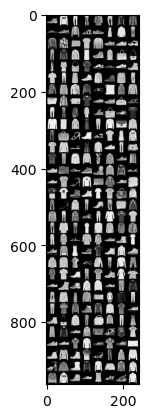

In [3]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [4]:
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):

        super(ConvModel, self).__init__()

        # Convulation layers
        self.con_1 = nn.Conv2d(in_channels=input_size[0], out_channels=17, kernel_size=5, padding=1)
        self.con_2 = nn.Conv2d(in_channels=17, out_channels=17, kernel_size=5, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten 
        self.flatten = nn.Flatten()

        # Linear layers
        self.fc_1 = nn.Linear(17 * 5 * 5, 145)
        self.fc_2 = nn.Linear(145, output_size)

        # Activation function
        self.relu = nn.ReLU()



    def forward(self, x):

        temp = self.pool(self.relu(self.con_1(x))) 
        temp = self.pool(self.relu(self.con_2(temp)))  
        temp = self.flatten(temp) 
        temp = self.relu(self.fc_1(temp))
        temp = self.fc_2(temp) 
        return temp

In [5]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):

    model.train()

    train_step_loss = 0
    correct = 0
    total = 0

    for image, label in train_loader:

        image, label = image.to(device), label.to(device)

        # Predictions
        y_train_logit = model(image)

        # Loss
        train_loss = loss_fn(y_train_logit, label)

        # L2 regularization
        l2_reg = sum(torch.norm(w) ** 2 for w in model.parameters())
        train_loss += reg_param * l2_reg

        # backward pass
        optimizer.zero_grad()
        train_loss.backward()

        optimizer.step()

        train_step_loss += train_loss.item()

        # Compute accuracy
        y_train_predicted = torch.softmax(y_train_logit, dim=1).argmax(dim=1)
        correct += torch.eq(y_train_predicted, label).sum().item()
        total += label.size(0)

    # Accuracy and loss
    avg_loss = train_step_loss / len(train_loader)
    train_accuracy = (correct / total) * 100

    return avg_loss, train_accuracy


In [6]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    
    model.eval()

    eval_step_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode(): 

        for image, label in data_loader:

            image, label = image.to(device), label.to(device)  

            # Predictions
            y_logit = model(image)

            # Loss
            loss = loss_fn(y_logit, label)

            # L2 regularization
            l2_reg = sum(torch.norm(param) ** 2 for param in model.parameters())
            loss += reg_param * l2_reg

            eval_step_loss += loss.item()

            # Compute accuracy
            y_predicted = torch.softmax(y_logit, dim=1).argmax(dim=1)
            correct += torch.eq(y_predicted, label).sum().item()
            total += label.size(0)

    avg_loss = eval_step_loss / len(data_loader)
    accuracy = (correct / total) * 100

    return avg_loss, accuracy 

In [7]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  

    # Model
    input_size =[1, 28, 28]
    output_size = 10
    model = ConvModel(input_size, output_size).to(device)

    num_epochs = 15

    # 20, 0.00404 performed well

    # Tuning parameters
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    reg_param = 0.0001

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []


    for epoch in range(num_epochs):
        
        # Training
        train_loss, train_acc = train_step(model,train_loader, loss_fn, optimizer, reg_param, device)
        
        # Validation set eval
        valid_loss, valid_acc = evaluation_step(model, valid_loader, loss_fn, reg_param, device)

        # Testing set eval 
        test_loss, test_acc = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        
        scheduler.step()

        # Tracking
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)


        # Print progress (note) it does take some time to fully train
        print(f"Epoch {epoch} | "
              f"Train Loss: {train_loss:5f}, Train Accuracy: {train_acc:.2f}% | "
              f"Valid Loss: {valid_loss:.5f}, Valid Accuracy: {valid_acc:.2f}% | "
              f"Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies

In [8]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
   
   plt.figure(figsize=(10, 8))

   # Plots 
   plt.plot(train_accuracies, color="red", label="training accuracy")
   plt.plot(test_accuracies, color="blue", label="testing accuracy")
   plt.plot(valid_accuracies, color="orange", label="validation accuracy")

   # Labels
   plt.title("Accuracy Performance")
   plt.xlabel("epoch")
   plt.ylabel("accuracy")

   plt.grid(alpha=0.5)
   plt.legend(loc="lower right")
   plt.show()

In [9]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
  
  plt.figure(figsize=(10, 8))

  # Plots 
  plt.plot(train_losses, color="red", label="training loss")
  plt.plot(test_losses, color="blue", label="testing loss")
  plt.plot(valid_accuracies, color="orange", label="validation loss")

  # Labels 
  plt.title("Loss Performance")
  plt.xlabel("epoch")
  plt.ylabel("Cross Entropy Loss")

  plt.grid(alpha=0.5)
  plt.legend(loc="lower right")
  plt.show()

In [10]:
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 0 | Train Loss: 0.626763, Train Accuracy: 77.28% | Valid Loss: 0.42383, Valid Accuracy: 85.18% | Test Loss: 0.43986, Test Accuracy: 84.71%
Epoch 1 | Train Loss: 0.381579, Train Accuracy: 86.83% | Valid Loss: 0.35587, Valid Accuracy: 87.83% | Test Loss: 0.37459, Test Accuracy: 87.14%
Epoch 2 | Train Loss: 0.334242, Train Accuracy: 88.75% | Valid Loss: 0.33774, Valid Accuracy: 88.68% | Test Loss: 0.35572, Test Accuracy: 88.03%
Epoch 3 | Train Loss: 0.307069, Train Accuracy: 89.87% | Valid Loss: 0.31846, Valid Accuracy: 89.38% | Test Loss: 0.33802, Test Accuracy: 89.07%
Epoch 4 | Train Loss: 0.288874, Train Accuracy: 90.53% | Valid Loss: 0.31475, Valid Accuracy: 89.39% | Test Loss: 0.33254, Test Accuracy: 88.81%
Epoch 5 | Train Loss: 0.274848, Train Accuracy: 91.10% | Valid Loss: 0.32130, Valid Accuracy: 89.19% | Test Loss: 0.33334, Test Accuracy: 88.80%
Epoch 6 | Train Loss: 0.263274, Train Accuracy: 91.62% | Valid Loss: 0.30432, Valid Accuracy: 90.53% | Test Loss: 0.31750, Test Ac

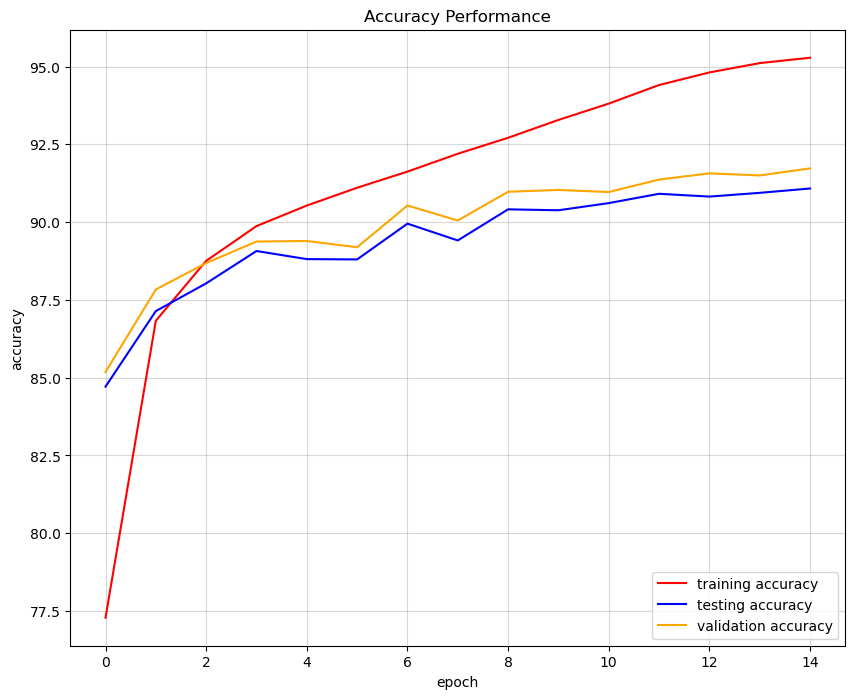

In [11]:
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

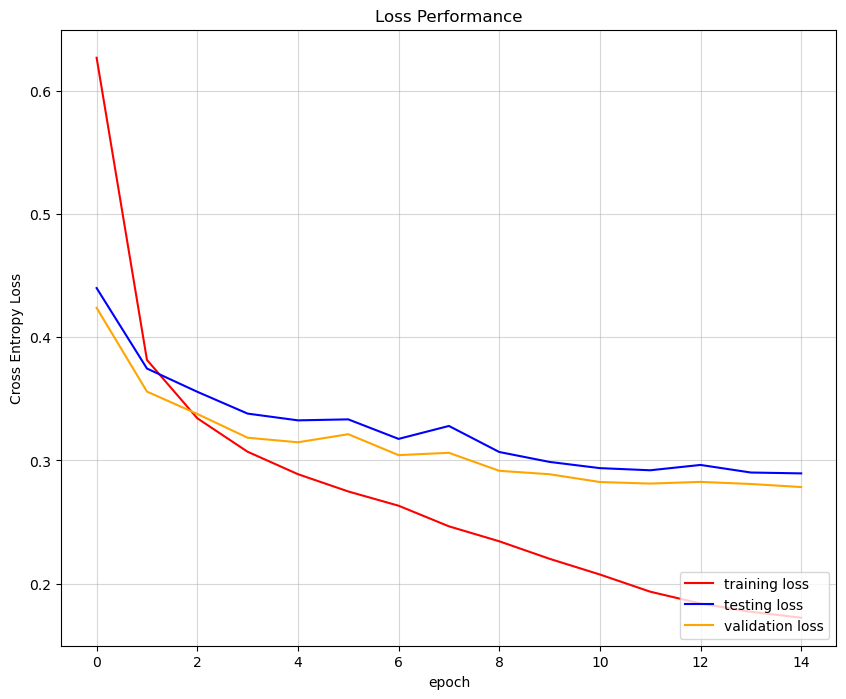

In [12]:
plot_loss_performance(train_losses, valid_losses, test_losses)